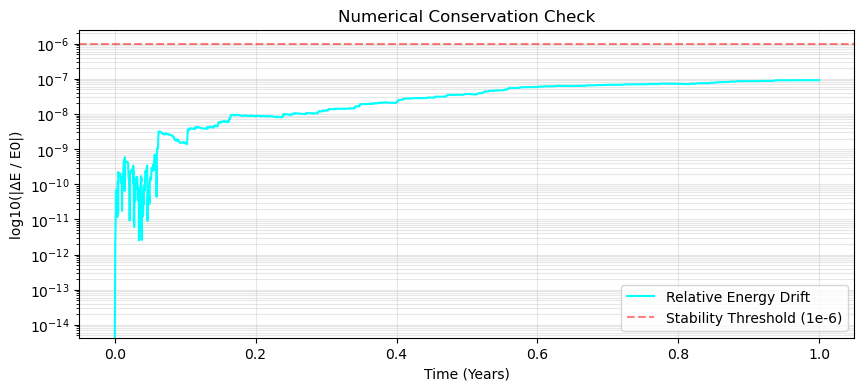

Final Energy Drift: 9.17e-08


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
from IPython.display import HTML

# 1. PHYSICAL CONSTANTS
G = 6.67430e-11  
Msun = 1.989e30  
AU = 1.496e11    
KM = 1000        
MStar = 1.080 * Msun
Mb = 0.0155 * 1.898e27 
Mc = 0.00278 * 1.898e27 

# 2. PHYSICS ENGINE
def N_body_system(state, t, M1, M2, M3):
    x1, y1, vx1, vy1, x2, y2, vx2, vy2, x3, y3, vx3, vy3 = state
    
    # Distance magnitudes
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    # Accelerations
    dvx1_dt = G * (M2 * (x2 - x1)/r12**3 + M3 * (x3 - x1)/r13**3)
    dvy1_dt = G * (M2 * (y2 - y1)/r12**3 + M3 * (y3 - y1)/r13**3)
    
    dvx2_dt = G * (M1 * (x1 - x2)/r12**3 + M3 * (x3 - x2)/r23**3)
    dvy2_dt = G * (M1 * (y1 - y2)/r12**3 + M3 * (y3 - y2)/r23**3)
    
    dvx3_dt = G * (M1 * (x1 - x3)/r13**3 + M2 * (x2 - x3)/r23**3)
    dvy3_dt = G * (M1 * (y1 - y3)/r13**3 + M2 * (y2 - y3)/r23**3)
    
    # Return as [dx1, dy1, dvx1, dvy1, ...]
    return [vx1, vy1, dvx1_dt, dvy1_dt,
            vx2, vy2, dvx2_dt, dvy2_dt,
            vx3, vy3, dvx3_dt, dvy3_dt]

def calculate_total_energy(state, M1, M2, M3):
    x1, y1, vx1, vy1, x2, y2, vx2, vy2, x3, y3, vx3, vy3 = state
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    K = 0.5 * (M1*(vx1**2 + vy1**2) + M2*(vx2**2 + vy2**2) + M3*(vx3**2 + vy3**2))
    U = -G * (M1*M2/r12 + M1*M3/r13 + M2*M3/r23)
    return K + U

# 3. INITIAL CONDITIONS & SOLVING (MOVED UP)
initial_state = [0, 0, 0, 0,                                # Star
                 0.2946*AU, 0, 0, 57.04*KM,                # Planet b
                 0, 0.04350*AU, 148.4*KM, 0]                # Planet c

years = 1
t = np.linspace(0, years * 365.25 * 24 * 3600, 5000)

# Solver with precision settings
solution = odeint(N_body_system, initial_state, t, args=(MStar, Mb, Mc), rtol=1e-10, atol=1e-12)

# Scaling for plots
x1, y1 = solution[:, 0]/AU, solution[:, 1]/AU
x2, y2 = solution[:, 4]/AU, solution[:, 5]/AU
x3, y3 = solution[:, 8]/AU, solution[:, 9]/AU
t_years = t / (365.25 * 24 * 3600)

# 4. ENERGY CALCULATION (MOVED AFTER SOLVING)
E0 = calculate_total_energy(initial_state, MStar, Mb, Mc)
energies = np.array([calculate_total_energy(row, MStar, Mb, Mc) for row in solution])
relative_change = np.abs((energies - E0) / E0)

# 5. VISUALIZATION
# Energy Plot
plt.figure(figsize=(10, 4))
plt.plot(t_years, relative_change, color='cyan', label='Relative Energy Drift')
plt.yscale('log')
plt.axhline(y=1e-6, color='r', linestyle='--', alpha=0.5, label='Stability Threshold (1e-6)')
plt.title('Numerical Conservation Check')
plt.ylabel('log10(|ΔE / E0|)')
plt.xlabel('Time (Years)')
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()
plt.show()

# Animation Setup
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_facecolor('black')
ax.set_xlim(-0.35, 0.35)
ax.set_ylim(-0.35, 0.35)
ax.set_aspect('equal')

line1, = ax.plot([], [], 'yo', markersize=12, label='Kepler-1047')
line2, = ax.plot([], [], 'bo', markersize=7, label='Planet b')
line3, = ax.plot([], [], 'go', markersize=5, label='Planet c')
trail2, = ax.plot([], [], 'b-', alpha=0.3)
trail3, = ax.plot([], [], 'g-', alpha=0.3)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

def update(frame):
    line1.set_data([x1[frame]], [y1[frame]])
    line2.set_data([x2[frame]], [y2[frame]])
    line3.set_data([x3[frame]], [y3[frame]])
    start = max(0, frame - 400)
    trail2.set_data(x2[start:frame], y2[start:frame])
    trail3.set_data(x3[start:frame], y3[start:frame])
    ax.set_title(f'Time: {t_years[frame]:.3f} Years', color='white')
    return line1, line2, line3, trail2, trail3

ani = FuncAnimation(fig, update, frames=range(0, len(t), 15), blit=True, interval=30)
plt.close()

print(f"Final Energy Drift: {relative_change[-1]:.2e}")
display(HTML(ani.to_jshtml()))